#  Practical Work 2

Writer: E.W

Date: 2024/05/26

## CNN from scratch

In [1]:
%load_ext lab_black
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

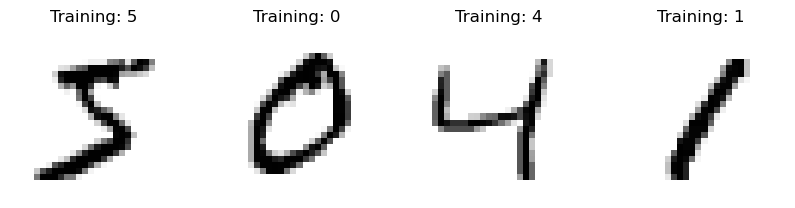

In [2]:
train_data = torchvision.datasets.MNIST(
    root="./mnist/",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.MNIST(
    root="./mnist/",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, train_data.data, train_data.targets):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [3]:
BATCH_SIZE = 32
train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [4]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [5]:
class CNN(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(n_input, n_hidden, 5, 1, 2),
            nn.ReLU(),
            nn.Conv2d(n_hidden, n_hidden, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(n_hidden, n_hidden, 5, 1, 2),
            nn.ReLU(),
            nn.Conv2d(n_hidden, n_hidden, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(n_hidden * 7 * 7, n_output)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

In [6]:
device = torch.device("mps")
model = CNN(1, 16, len(train_data.classes)).to(device)

In [7]:
model

CNN(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()


def train(model, data_loader, optimizer, loss_func, device):
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_func(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}")


def test(model, data_loader, device):
    model.eval()
    test_loss, test_accuracy = 0, 0
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred_labels = torch.argmax(y_pred, dim=1)
            test_accuracy += torch.sum(y == y_pred_labels).item()
            loss = loss_func(y_pred, y)
            test_loss += loss.item()
    test_accuracy = 100.0 * test_accuracy / len(test_loader.dataset)
    test_loss /= len(test_loader)
    print(f"Test loss:{test_loss:.5f} | Test accuracy:{test_accuracy:.5f}")

In [9]:
for i in range(5):
    print(f"Epoch {i+1}")
    train(model, train_loader, optimizer, loss_func, device)
    test(model, test_loader, device)

Epoch 1
Train loss: 0.24217
Test loss:0.12740 | Test accuracy:95.94000
Epoch 2
Train loss: 0.13488
Test loss:0.11239 | Test accuracy:96.63000
Epoch 3
Train loss: 0.12392
Test loss:0.12687 | Test accuracy:96.05000
Epoch 4
Train loss: 0.11720
Test loss:0.09645 | Test accuracy:96.79000
Epoch 5
Train loss: 0.11732
Test loss:0.09944 | Test accuracy:96.91000
